# Hough Transform
- https://sites.ecse.rpi.edu/~qji/CV/HTX.pdf
- https://docs.opencv.org/3.4/da/d53/tutorial_py_houghcircles.html

Decided not to use - better for detecting full circles, not partial ones

In [1]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt

In [4]:
img = np.load("data/images/image8.npy")
img_gray = img/img.max()*255
img_gray = img_gray.astype(np.uint8)

img_gray = cv.medianBlur(img_gray, 5)
cv.imshow("img_gray", img_gray)

: 

# Taking Lineouts

In [2]:
import numpy as np
import matplotlib.pyplot as plt
master_dark = np.load('data/master_dark.npy')
img = np.load('data/images/image8.npy')
img -= master_dark

In [3]:
def make_lineout(img, y, dy, xavg_period):
    """Return a lineout of the image at y +- dy, averaging over xavg_period pixels."""
    lineout = np.zeros(img.shape[1]-xavg_period)

    for x in range(img.shape[1]-xavg_period):
        lineout[x] = np.mean(img[y-dy:y+dy, x:x+xavg_period])
    
    return lineout

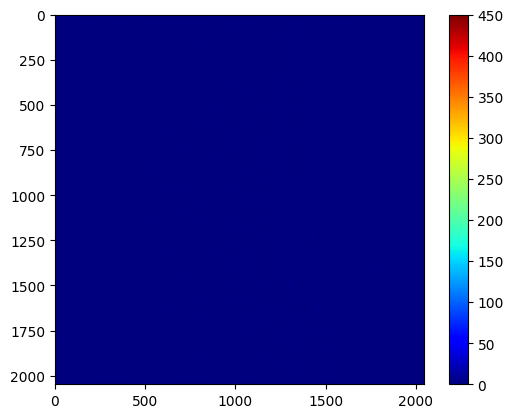

In [4]:
%matplotlib inline

from new_spc import get_all_hits_and_locations, create_image_of_hits
from histograms import make_histogram
# Get all hits and their locations
primary_threshold = 75
secondary_threshold = 30
n_sigma = 2
hits, locations = get_all_hits_and_locations(img, primary_threshold, secondary_threshold, n_sigma)
hit_image = create_image_of_hits(img.shape, hits, locations)

plt.imshow(hit_image, cmap="jet", vmin=0, vmax=450)
plt.colorbar()


array([1267, 1270, 1277, 1280, 1407, 1413], dtype=int64)

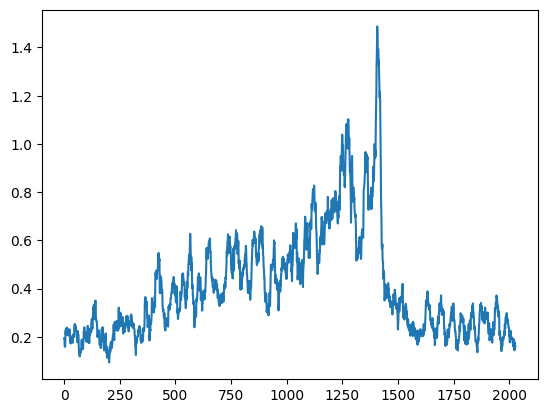

In [47]:
from scipy.signal import find_peaks
plt.plot(make_lineout(hit_image, 1000, 200, 20))
#plt.plot(make_lineout(hit_image, 200, 200, 20))
#plt.plot(make_lineout(hit_image, 1800, 200, 20))

peaks, _ = find_peaks(make_lineout(hit_image, 1000, 500, 20), height=1)
peaks

## Comment on peak detection

To get well-defined peaks on a lineout, we have to average over a large range of y values. This means we are less able to precisely determine the location of the peak centre, and also cannot get as close to the edges of the image to determine the side points.

To fix this, we can convolve the image with a Sobel kernel. A Sobel kernel attempts to approximate the derivative of the image in different directions. Since we are looking for peaks in approximately the x direction, we can use the x Sobel kernel to do this.

Traditionally, the Sobel kernel is defined as a 3x3 matrix

$$
\begin{pmatrix}
1 & 0 & -1\\
2 & 0 & -2\\
1 & 0 & -1\\
\end{pmatrix}
$$

However, data points in our images are much more sparse, so we can generalise this to an $n$ x $n$ matrix. This is done by projecting gradients onto the direction of interest, more detail (here)[https://stackoverflow.com/questions/9567882/sobel-filter-kernel-of-large-size].

We are also only interested in the size of the gradient to locate a peak, so we take the absolute value.

In [56]:
def custom_sobel(shape, axis):
    """
    shape must be odd: eg. (5,5)
    axis is the direction, with 0 to positive x and 1 to positive y
    """
    k = np.zeros(shape)
    p = [(j,i) for j in range(shape[0]) 
           for i in range(shape[1]) 
           if not (i == (shape[1] -1)/2. and j == (shape[0] -1)/2.)]

    for j, i in p:
        j_ = int(j - (shape[0] -1)/2.)
        i_ = int(i - (shape[1] -1)/2.)
        k[j,i] = (i_ if axis==0 else j_)/float(i_*i_ + j_*j_)
    return k

kernel = np.abs(custom_sobel((25, 25), 0))

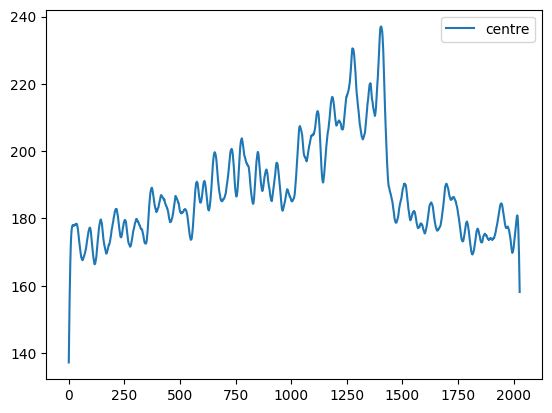

In [73]:
from scipy import ndimage
import numpy as np
%matplotlib inline
"""kernel = np.array([
    [-1,2,-1],
    [-1,2,-1],
    [-1,2,-1]
], dtype=np.int32)
"""

preprocessed = np.clip(img, 0, 255).astype(np.int32)

edges = ndimage.convolve(preprocessed, kernel, mode="constant", cval=0.0)

edges_lineout = make_lineout(edges, 1000, 100, 20)

plt.plot(edges_lineout, label="centre")
"""plt.plot(make_lineout(edges, 200, 100, 20), label="bottom")
plt.plot(make_lineout(edges, 1800, 100, 20), label="top")"""
plt.legend()

These peaks are much clearer, and we used a much smaller y averaging range. We can use `scipy`'s `find_peaks` function to easily locate the two peaks.

Another benefit of this method is taht is is shape agnistic - it does not require us to see a full circle or anything.

NB larger y averaging ranges should give more well defined peaks, at the expense of these locations not being as accurate.

However, in this range, the circle should be roughly linear, so any averaging should cancel out on each side of the centre of the lineout and ensure we get the centre value. This does not hold as well for the centre of the circle, since the effect of the averaging will be to push the peak towards the centre of the circle.

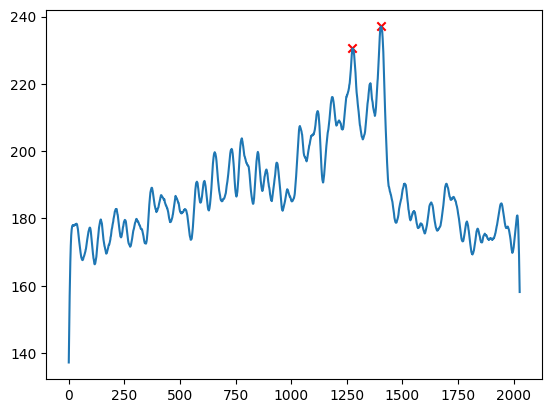

In [69]:
# Find all the peaks, that are at least 100 pixels apart
# smaller peaks are removed until all peaks are at least 100 pixels apart
# (see scipy documentation)
peaks, _ = find_peaks(edges_lineout, distance=100)

# get the largest 2 peaks
peaks = peaks[np.argsort(edges_lineout[peaks])[-2:]]
peaks, edges_lineout[peaks]

plt.plot(edges_lineout)
plt.scatter(peaks, edges_lineout[peaks], c="r", marker = "x")